In [1]:
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
%matplotlib widget

In [2]:
exps = ['Test 9']
rms = {}

for test in exps:
    rms[test] = RMS(test)
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass


Loaded Test 9 RMS Data


In [3]:
vae = VariationalAutoEncoder(rms[test],
                                     tb=False,
                                     tb_logdir=rms[test].exp_name,
                                     train_slice=(0, 100),
                                     random_state=1,
                                     params={'latent_dim': 2,
                                             'n_size': [64, 64],
                                             'epochs': 500,
                                             'batch_size': 10,
                                             }
                                     )

vae.fit(x=vae.train_data,
        val_data=vae.val_data,
        verbose=0,
        use_multiprocessing=True,
        )

Pre-Processing Data:
	Training Data: slice(0, 100, None)
	Input train shape: (90, 394)
	Input val shape: (10, 394)

VAE-TEST_9-E-500-L-[64, 64, 'Z', 64, 64]-T-20230411-091509



Training:   0%|           0/500 ETA: ?s,  ?epochs/s

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Epochs', ylabel='Loss'>)

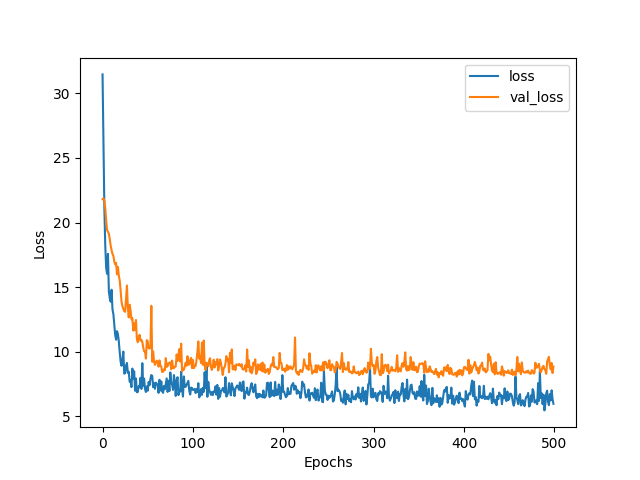

In [4]:
vae.loss_plot()

In [5]:
pred_tr, scores_tr = vae.score('train')
pred_val, scores_val = vae.score('val')
pred_data, scores_data = vae.score('dataset')


Train Scores:
	MAE: 0.08693
	MSE: 0.01291
	R2: 0.47600

Val Scores:
	MAE: 0.11083
	MSE: 0.02127
	R2: 0.26103

Dataset Scores:
	MAE: 0.16486
	MSE: 0.07154
	R2: 0.05144


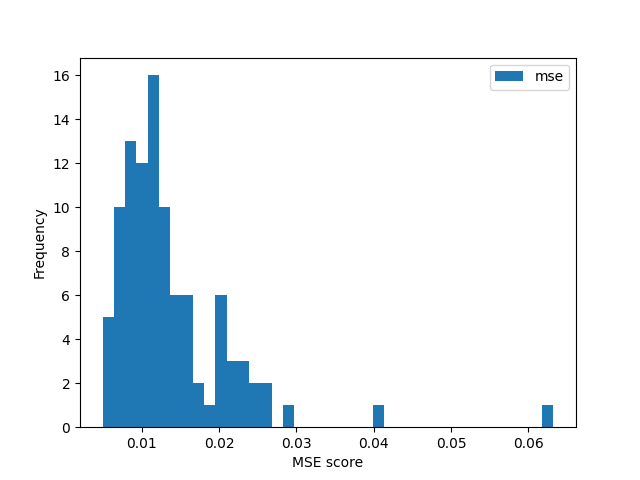

In [6]:
fig, ax = vae.hist_scores(['mse'])

Text(0.5, 1.0, 'TEST_9 Val Data - MAE: 0.0862 MSE: 0.0145')

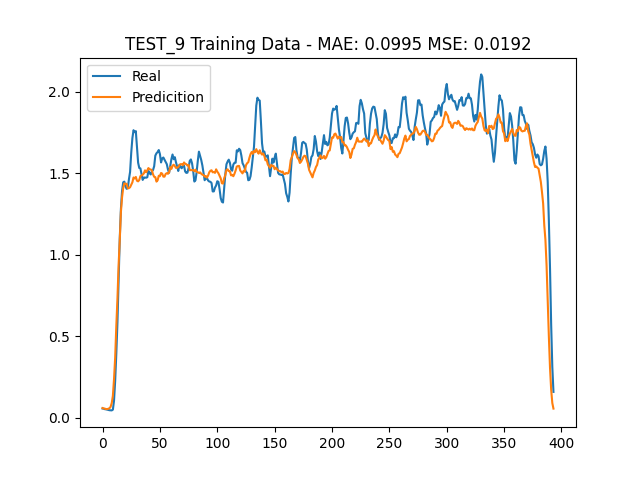

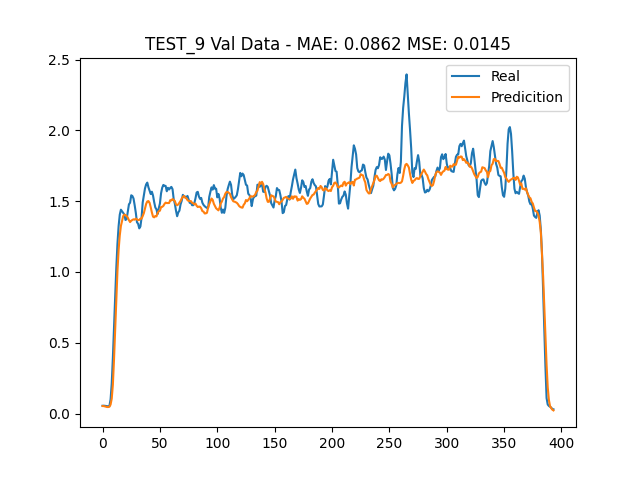

In [7]:
fig, ax = vae.pred_plot(vae._ind_tr[0])
ax.set_title(f'{vae.RMS.exp_name} Training Data - {ax.get_title()}')
fig, ax = vae.pred_plot(vae._ind_val[0])
ax.set_title(f'{vae.RMS.exp_name} Val Data - {ax.get_title()}')

In [8]:
vae.thres


Cutoffs:
	MAE cutoff: 0.11189
	MSE cutoff: 0.02159
	R2 cutoff: 0.16129


{'mae': 0.11189195913841145,
 'mse': 0.021592078162840027,
 'r2': 0.16128543089730069}

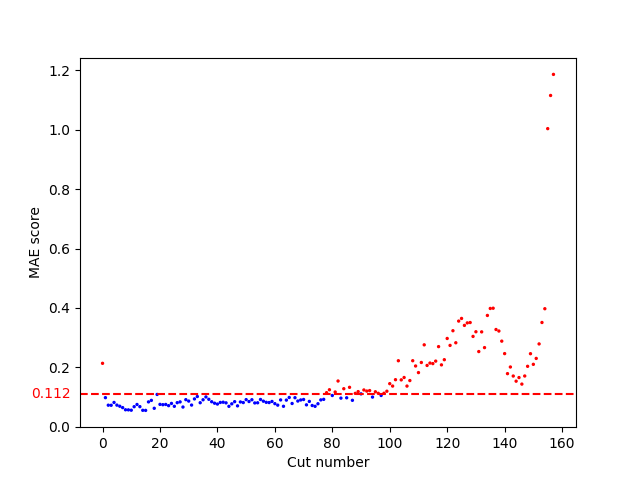

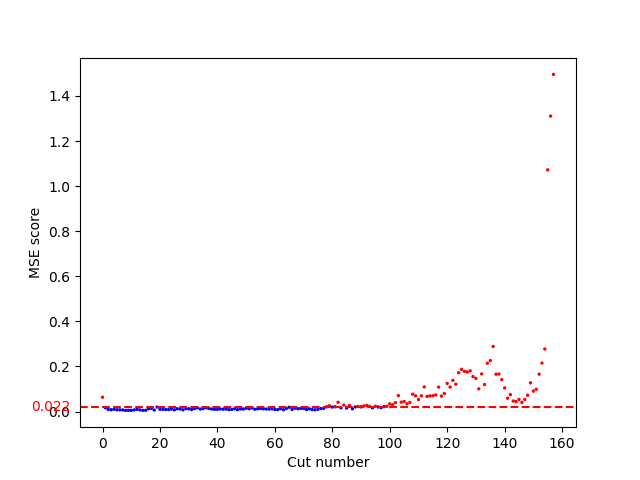

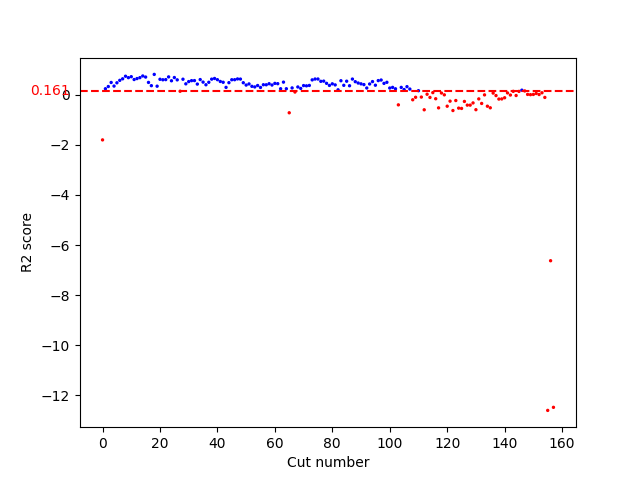

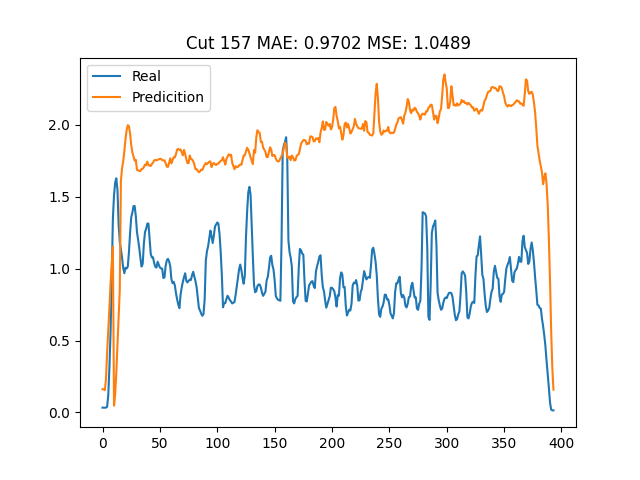

In [9]:
fig, ax = vae.scatter_scores()

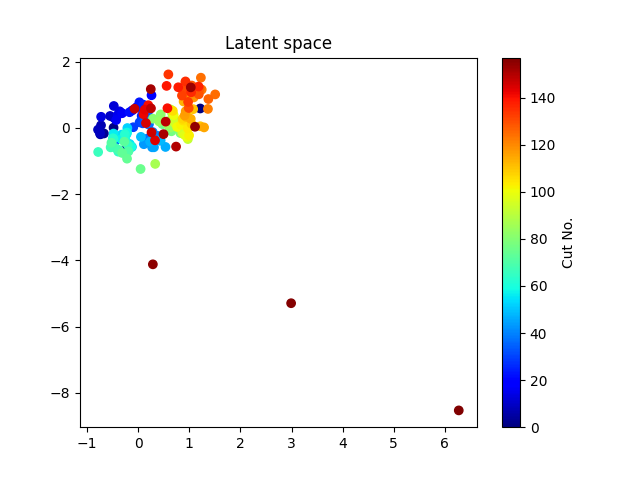

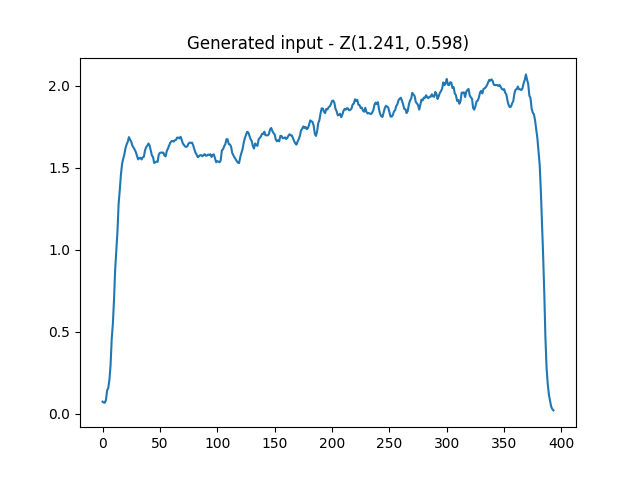

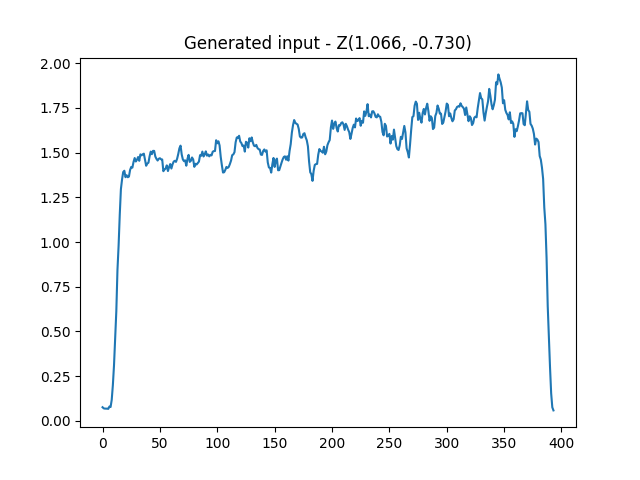

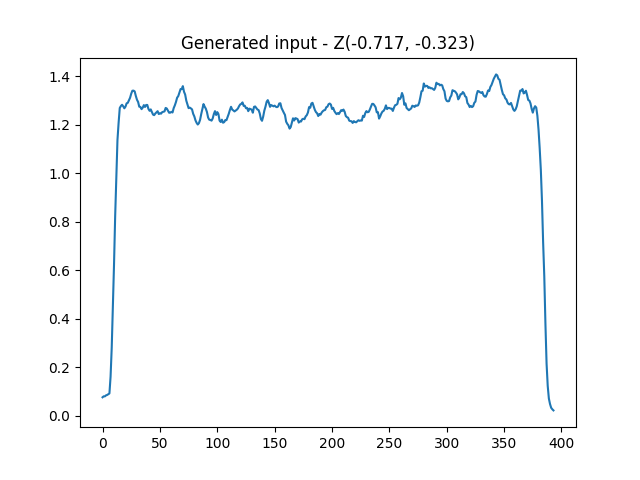

In [10]:
fig, ax = vae.plot_latent_space()